<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/feature_extractor_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib
from skimage import feature, io, color

In [5]:
import pandas as pd
csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_data_reduced.csv'
column_names = ['path', 'index', 'label']
df_train = pd.read_csv(csv_file_path, names=column_names)
df_train = df_train.iloc[1:]
df_train = df_train.reset_index(drop=True)

In [4]:
# preprocess and pipeline

def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]


def histogram_clipping(img, threshold_value):
  clipped_image = img.copy()
  # before
  # draw_histogram_gray(clipped_image)
  clipped_image[img < threshold_value/255.0] = 0
  # Normalize the clipped_image to 0-255 for proper histogram visualization
  normalized_clipped_image = cv2.normalize(clipped_image, None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  # draw_histogram_gray(clipped_image)
  return normalized_clipped_image

def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3)):
  block_norm = 'L1'  # Block normalization method
  # orientations = 9   # Number of orientation bins
  # pixels_per_cell = (8, 8)  # Size of the cell
  # cells_per_block = (3, 3)  # Size of the block

  # Compute the HOG features
  hog_features, hog_image = feature.hog(img_gray,
                                        orientations=orientations,
                                        pixels_per_cell=pixels_per_cell,
                                        cells_per_block=cells_per_block,
                                        block_norm=block_norm,
                                        visualize=True)
  return hog_features, hog_image

def preprocess_1(df):
  image_dir = df['path'] # ignore index
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_sobel = sobel_preprocessing(im_bilateral, 31)
    im_canny = canny_filter(im_blurred, 70, 0)
    im_cropped = crop_center(im_canny, 252, 252)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed

def preprocess_2(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    hog_feature, hog_image = hog(im_cropped) #(63504,)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(hog_feature)

  df_preprocessed = pd.DataFrame(preprocessed_list)
  return df_preprocessed


def preprocess_resnet(df):
  image_dir = df['path']
  preprocessed_list = []

  for i, image_path in enumerate(image_dir):
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 240, 240)
    # im_flattened = hog_feature.flatten()
    preprocessed_list.append(im_cropped)

  return preprocessed_list

In [14]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(8, 6))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

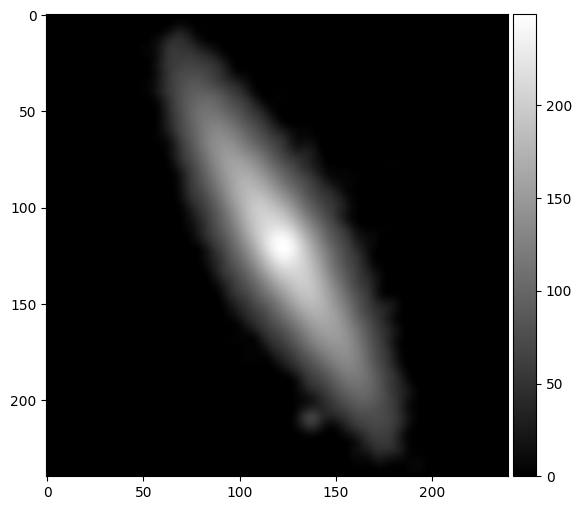

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = preprocess_resnet(df_train[:3])[0]
display_img_colorbar(img)